In [2]:
import numpy as np
import soundfile as sf
import scipy.signal
import matplotlib.pyplot as plt
import os

def calculate_delay(farend_path, echo_path, plot=True):
    """
    Tính toán độ trễ (lag) giữa Far-end và Echo sử dụng Cross-Correlation.
    """
    # 1. Load file
    if not os.path.exists(farend_path):
        print(f"❌ Error: File not found: {farend_path}")
        return None
    if not os.path.exists(echo_path):
        print(f"❌ Error: File not found: {echo_path}")
        return None

    x, sr_x = sf.read(farend_path) # Far-end (Reference)
    y, sr_y = sf.read(echo_path)   # Echo (Mic input)

    # Kiểm tra sample rate
    if sr_x != sr_y:
        print(f"⚠️ Warning: Sample rate mismatch ({sr_x} vs {sr_y}). Results may be inaccurate.")
        # Resample về sr_x (đơn giản hoá cho code check)
        num_samples = int(len(y) * float(sr_x) / sr_y)
        y = scipy.signal.resample(y, num_samples)
        sr = sr_x
    else:
        sr = sr_x

    # Chuyển về Mono nếu là Stereo (Lấy kênh đầu tiên hoặc trung bình)
    if len(x.shape) > 1: x = x[:, 0]
    if len(y.shape) > 1: y = y[:, 0]

    # Chuẩn hóa biên độ (Normalization) để cross-correlation hoạt động tốt
    x = x / (np.max(np.abs(x)) + 1e-9)
    y = y / (np.max(np.abs(y)) + 1e-9)

    # 2. Tính Cross-Correlation
    # mode='full' trả về kết quả đầy đủ của phép tích chập
    correlation = scipy.signal.correlate(y, x, mode='full', method='fft')
    
    # 3. Tìm đỉnh (Peak)
    # Lags là trục thời gian của correlation
    lags = scipy.signal.correlation_lags(len(y), len(x), mode='full')
    
    peak_idx = np.argmax(np.abs(correlation))
    lag_samples = lags[peak_idx]
    
    # Đổi sang thời gian (giây và mili-giây)
    time_delay_sec = lag_samples / sr
    time_delay_ms = time_delay_sec * 1000

    print(f"\n📊 --- KẾT QUẢ PHÂN TÍCH ---")
    print(f"File Far-end: {os.path.basename(farend_path)}")
    print(f"File Echo:    {os.path.basename(echo_path)}")
    print(f"Sample Rate:  {sr} Hz")
    print(f"Độ trễ mẫu (Lag samples): {lag_samples}")
    print(f"Độ trễ thời gian: {time_delay_ms:.2f} ms")

    if lag_samples > 0:
        print("=> KẾT LUẬN: Echo ĐI SAU Far-end (Delay dương).")
    elif lag_samples < 0:
        print("=> KẾT LUẬN: Echo ĐI TRƯỚC Far-end (Vô lý về vật lý, có thể do file bị cắt).")
    else:
        print("=> KẾT LUẬN: Đồng bộ hoàn toàn (Delay = 0).")

    # 4. Vẽ biểu đồ (Optional)
    if plot:
        plt.figure(figsize=(10, 6))
        
        # Plot 1: Tín hiệu gốc
        plt.subplot(2, 1, 1)
        time_x = np.arange(len(x)) / sr
        time_y = np.arange(len(y)) / sr
        plt.plot(time_x, x, label='Far-end (Ref)', alpha=0.7)
        plt.plot(time_y, y, label='Echo', alpha=0.7)
        plt.title('Waveforms ban đầu')
        plt.legend()
        plt.grid(True)

        # Plot 2: Cross-Correlation
        plt.subplot(2, 1, 2)
        plt.plot(lags, correlation)
        plt.axvline(lag_samples, color='r', linestyle='--', label=f'Peak at {lag_samples} samples')
        plt.title(f'Cross-Correlation (Peak Lag: {time_delay_ms:.2f} ms)')
        plt.xlabel('Lag (Samples)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return lag_samples, time_delay_ms


📊 --- KẾT QUẢ PHÂN TÍCH ---
File Far-end: farend_speech_fileid_5.wav
File Echo:    echo_fileid_5.wav
Sample Rate:  16000 Hz
Độ trễ mẫu (Lag samples): 477
Độ trễ thời gian: 29.81 ms
=> KẾT LUẬN: Echo ĐI SAU Far-end (Delay dương).


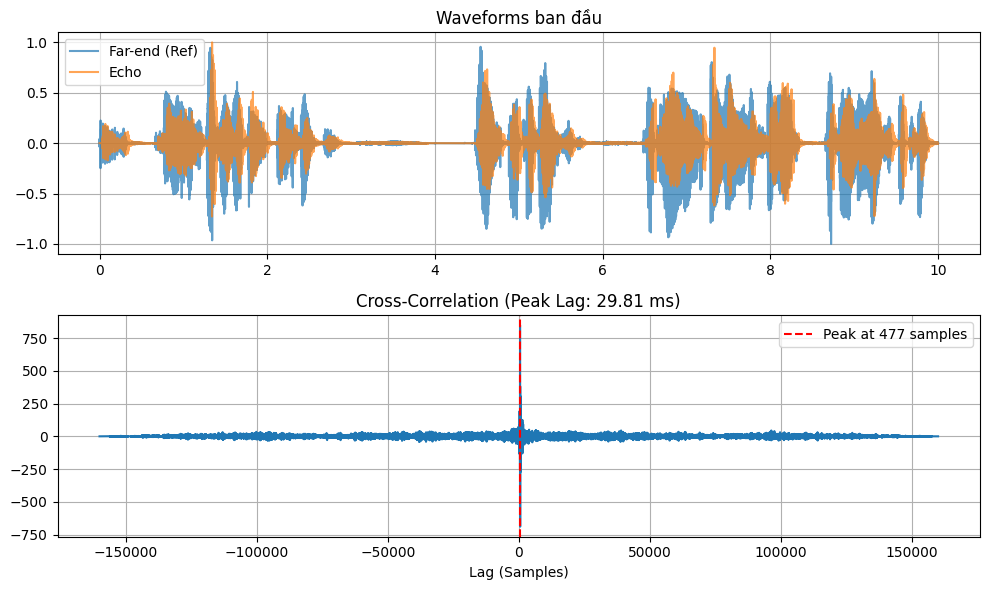

(np.int64(477), np.float64(29.8125))

In [3]:
FILE_FAREND = "D:/aec/AEC-Challenge/datasets/synthetic/farend_speech/farend_speech_fileid_5.wav"
FILE_ECHO = "D:/AEC-Challenge/datasets/synthetic/echo_signal/echo_fileid_5.wav"
    
# Chạy kiểm tra
calculate_delay(FILE_FAREND, FILE_ECHO, plot=True)